# Import section

In [1]:
%load_ext autoreload
%autoreload 2

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import scikitplot as skplot
from sklearn import linear_model
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.decomposition import PCA

from context import ml_project
from ml_project.io import DataHandler

In [2]:
# To surpress sklearn warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Download data - HowTo

1) Download the zip folder holding the data  
2) Create a directory inside the <PROJECT_ROOT_DIR>/data and give it a suitable name <DIR_NAME>, e.g. "task1a_data"   
3) Extract the files from the zip folder into <DIR_NAME>  
4) Set the correct <DIR_NAME> in the following cell...  

In [3]:
DIR_NAME = 'task1a_data'

# Load training data

In [4]:
data_handler = DataHandler(DIR_NAME)
train_data = data_handler.load_train_data()

train_X = train_data.drop(['y'], axis=1)
train_Y = train_data['y']

train_data_full = pd.concat([train_Y, train_X], axis=1)

In [16]:
train_data_full.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
Id,,,,,,,,,,,
0,508.451970,0.886865,0.400531,1.103694,0.135455,8.148069,9.787555,79.749674,0.045166,1.859346,1.0
1,3972.980713,0.303604,-1.661598,0.772695,1.696182,0.455550,86.413653,39.365705,-0.014858,0.821406,1.0
2,-1.084332,1.065927,-1.607320,0.063896,-0.724311,-0.088216,0.132828,-0.011718,-0.773193,-1.489933,1.0
3,-340.149697,0.049530,-0.780820,-1.653181,0.663369,-2.492097,-1.243722,3.099476,-1.037881,0.346979,1.0
4,572.648651,0.417725,-1.150429,0.258384,0.045522,5.676019,-0.470274,-2.669283,0.632083,-0.510847,1.0


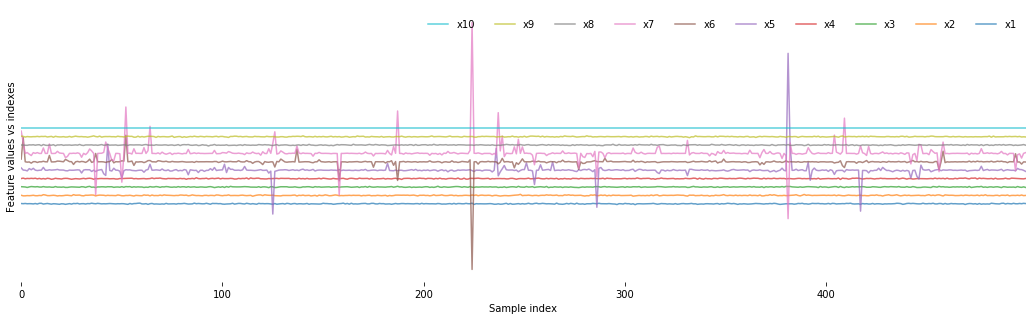

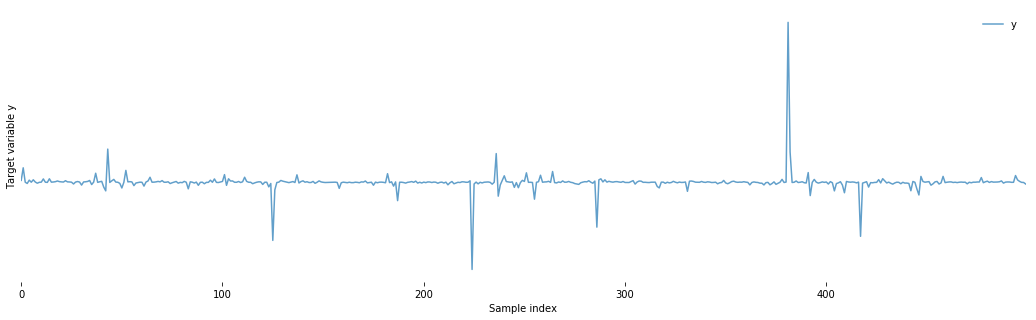

In [6]:
# Explore the correlatio of y and the feature values

def plot_columns_serieses(df, columns=None, y_label='', x_label='Sample index'):
    train_plot_X = df.copy()
    
    if columns:
        train_plot_X = train_plot_X[columns]
    
    if hasattr(train_plot_X, 'columns'):
        offset_val = 30
        for idx, col in enumerate(train_plot_X.columns):
            train_plot_X[col] = train_plot_X[col] + offset_val * idx

    ax = train_plot_X.plot(figsize=(18, 5), legend=False, alpha=0.7)
    sns.despine(left=True, bottom=True, right=True)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.get_yaxis().set_ticks([])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], facecolor='None', frameon=False, ncol=10)
    plt.show()
    
plot_columns_serieses(train_X, y_label='Feature values vs indexes')
plot_columns_serieses(train_data_full, columns='y', y_label='Target variable y')


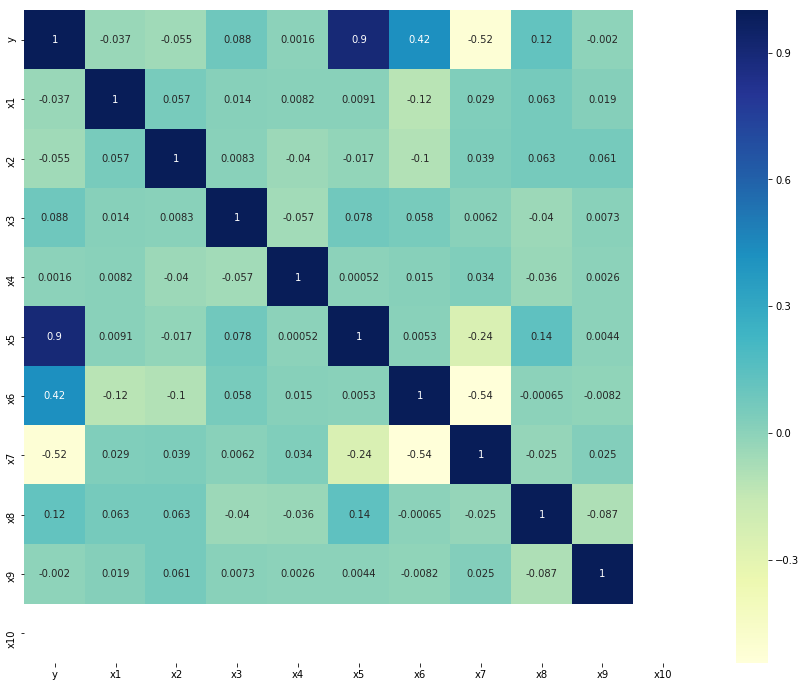

In [20]:
def sns_correlation_plot(data_frame):
    plt.figure(figsize=(15, 12))
    correlation = data_frame.corr() #corr() method of pandas library calculates correlation between columns of dataframe
    sns.heatmap(correlation, cmap="YlGnBu", annot=True)
    plt.show()

sns_correlation_plot(train_data_full)

In [ ]:
from pandas.plotting import scatter_matrix

_ = scatter_matrix(pd.concat([train_Y, train_X], axis=1), alpha=0.3, figsize=(12, 12))

# Feature engineering

In [29]:
# Based on the plot above, we can essentially concentrate our efforts on x5, x6 and x7
# TODO: Is that actually true? How to interpret the scatter matrix?

train_X_cleaned = train_X[['x5', 'x6', 'x7']]
train_X_cleaned['x56'] = train_X_cleaned['x5'] + train_X_cleaned['x6']
train_X_cleaned['x67'] = train_X_cleaned['x6'] + train_X_cleaned['x7']
train_X_cleaned['x57'] = train_X_cleaned['x5'] + train_X_cleaned['x7']
train_X_cleaned['x567'] = train_X_cleaned['x5'] + train_X_cleaned['x6'] + train_X_cleaned['x7']

#train_X_cleaned['xm56'] = train_X_cleaned['x5'] * train_X_cleaned['x6']
#train_X_cleaned['xm67'] = train_X_cleaned['x6'] * train_X_cleaned['x7']
#train_X_cleaned['xm57'] = train_X_cleaned['x5'] * train_X_cleaned['x7']
#train_X_cleaned['xm567'] = train_X_cleaned['x5'] * train_X_cleaned['x6'] * train_X_cleaned['x7']

train_X_cleaned.head()

,x5,x6,x7,x56,x67,x57,x567
Id,,,,,,,
0,8.148069,9.787555,79.749674,17.935624,89.537229,87.897743,97.685298
1,0.455550,86.413653,39.365705,86.869203,125.779358,39.821255,126.234908
2,-0.088216,0.132828,-0.011718,0.044612,0.121110,-0.099934,0.032894
3,-2.492097,-1.243722,3.099476,-3.735819,1.855754,0.607379,-0.636343
4,5.676019,-0.470274,-2.669283,5.205746,-3.139557,3.006736,2.536462


In [30]:
"""
For each of the pre-defined regularization values, we create a Pipeline consisting of a the ridge regressor itself.
If we wanted, we could easily add more steps into the pipeline.
"""

ridge_alphas = [0.1, 1, 10, 100, 1000]

models = {}
for alpha_value in ridge_alphas:
    
    pipeline = Pipeline([('pca', PCA()),
                         ('regr', Ridge(alpha=alpha_value))])
    
    models[alpha_value] = pipeline

param_grid = {'pca__n_components': range(1, len(train_X_cleaned.columns) + 1),
              'regr__random_state': [1], # Fixing the random seed for reproducability
              'regr__normalize': [True, False]
             }

grid_cv_estimators = {}
for alpha_value, ridge_pipe in models.items():
    
    print('Training models with alpha value {}'.format(ridge_pipe.get_params()['regr__alpha']))
    
    grid_cv = GridSearchCV(ridge_pipe, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', verbose=False)
    grid_cv.fit(train_X_cleaned, train_Y)
    grid_cv_estimators[alpha_value] = grid_cv
    
    # print('\tAvg. RMSE of runs: ', grid_cv.cv_results_['mean_test_score'], '\n')

Training models with alpha value 0.1
Training models with alpha value 1
Training models with alpha value 10
Training models with alpha value 100
Training models with alpha value 1000


In [31]:
results = []

for alpha_val, cv_estimator in grid_cv_estimators.items():
    print('\n', 10 * '=', 'alpha = {}'.format(alpha_val), 10 * '=', '\n')
    print('Best param set: ')
    pprint(cv_estimator.best_params_)

    cv_results = cv_estimator.cv_results_
    
    best_ranked_idx = np.argmin(cv_results['rank_test_score'])
    results.append(cv_results['mean_test_score'][best_ranked_idx])
    
    print('\n', 10 * '-')
    print('Mean test scores for parameter combinations...')
    for mean, std, params in zip(cv_results['mean_test_score'], cv_results['std_test_score'], cv_results['params']):
        print("%0.3f (+/- %0.03f) for %r" % (mean, std * 2, params))
    print(10 * '-')


 ========== alpha = 0.1 ========== 

Best param set: 
{'pca__n_components': 3, 'regr__normalize': False, 'regr__random_state': 1}

 ----------
Mean test scores for parameter combinations...
-8711978.640 (+/- 24931869.586) for {'pca__n_components': 1, 'regr__normalize': True, 'regr__random_state': 1}
-8887083.638 (+/- 25158773.350) for {'pca__n_components': 1, 'regr__normalize': False, 'regr__random_state': 1}
-1616652.647 (+/- 8201713.471) for {'pca__n_components': 2, 'regr__normalize': True, 'regr__random_state': 1}
-1356735.049 (+/- 7065937.622) for {'pca__n_components': 2, 'regr__normalize': False, 'regr__random_state': 1}
-60525.632 (+/- 195686.763) for {'pca__n_components': 3, 'regr__normalize': True, 'regr__random_state': 1}
-1.014 (+/- 0.371) for {'pca__n_components': 3, 'regr__normalize': False, 'regr__random_state': 1}
-60548.643 (+/- 195700.959) for {'pca__n_components': 4, 'regr__normalize': True, 'regr__random_state': 1}
-1.014 (+/- 0.371) for {'pca__n_components': 4, 'reg

In [32]:
pos_results = [np.sqrt(-1.0 * entry) for entry in results]  # Since sklearn optimizes for high values of neg_mean_square_error

print('Mean squared error for alpha values of...\n')
for alpha, av_msqe in zip(ridge_alphas, pos_results):
    print('{:15}: {}'.format(alpha, av_msqe))


Mean squared error for alpha values of...

            0.1: 1.0071562176104554
              1: 1.0060778334099867
             10: 0.9992354299366534
            100: 1.28809708993667
           1000: 9.331795577771262


In [35]:
data_handler.store_results_task1a(pos_results)